# Predictive Modeling

**Objective:** Train and evaluate regression models for bike demand forecasting.

**Models:** Linear Regression and Random Forest

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## Data Loading

In [2]:
# Load dataset (same source as EDA)
df = pd.read_csv("SeoulBikeData.csv", encoding="latin1")

print("Rows, columns:", df.shape)


Rows, columns: (8760, 14)


## Feature Engineering and Preprocessing

In [3]:
# Define target and features
y = df["Rented Bike Count"]
X = df.drop(columns=["Rented Bike Count"])

In [4]:
# print column names and data types
print(X.dtypes)
print()
print(y.dtypes)

Date                          object
Hour                           int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object

int64


In [5]:
# Parse date and add basic calendar features
X["Date"] = pd.to_datetime(X["Date"], dayfirst=True, errors="coerce")
X["DayOfWeek"] = X["Date"].dt.dayofweek
DF_MONTH = X["Date"].dt.month
DF_MONTH.name = "Month"
X["Month"] = DF_MONTH

# drop original Date column
X = X.drop(columns=["Date"])

In [6]:
# Identify numeric and non-numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Non-numeric columns: {non_numeric_cols}")


Numeric columns: 11
Non-numeric columns: ['Seasons', 'Holiday', 'Functioning Day']


In [7]:
# Analyze non-numeric columns
for col in non_numeric_cols:
    print("\nColumn:")
    print(X[col].value_counts())


Column:
Seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: count, dtype: int64

Column:
Holiday
No Holiday    8328
Holiday        432
Name: count, dtype: int64

Column:
Functioning Day
Yes    8465
No      295
Name: count, dtype: int64


In [8]:
# Encode categorical variables

# 1. Binary encoding for Holiday (Holiday=1, No Holiday=0)
X['Holiday_Encoded'] = X['Holiday'].map({'Holiday': 1, 'No Holiday': 0})

# 2. Binary encoding for Functioning Day (Yes=1, No=0)
X['Functioning_Day_Encoded'] = X['Functioning Day'].map({'Yes': 1, 'No': 0})

# Remove all non-functioning days from the dataset
mask_functioning = X['Functioning_Day_Encoded'] == 1
X = X[mask_functioning].reset_index(drop=True)
y = y[mask_functioning].reset_index(drop=True)

# 3. One-hot encoding for Seasons
# Create dummy variables and drop the first to avoid multicollinearity
season_dummies = pd.get_dummies(X['Seasons'], prefix='Season', drop_first=True, dtype=int)
X = pd.concat([X, season_dummies], axis=1)

# 4. Drop the original categorical columns
columns_to_drop = ['Seasons', 'Holiday', 'Functioning Day', 'Functioning_Day_Encoded']
X = X.drop(columns=columns_to_drop)


In [9]:
# Remove Dew point temperature due to high correlation with Temperature
X = X.drop(columns=['Dew point temperature(°C)'])

In [10]:
print(f"\nNew feature set shape: {X.shape}")
print(f"\nColumns and data types:")
print(X.dtypes)
print(f"\nFirst few rows:")
print(X.head())


New feature set shape: (8465, 14)

Columns and data types:
Hour                         int64
Temperature(°C)            float64
Humidity(%)                  int64
Wind speed (m/s)           float64
Visibility (10m)             int64
Solar Radiation (MJ/m2)    float64
Rainfall(mm)               float64
Snowfall (cm)              float64
DayOfWeek                    int32
Month                        int32
Holiday_Encoded              int64
Season_Spring                int64
Season_Summer                int64
Season_Winter                int64
dtype: object

First few rows:
   Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
0     0             -5.2           37               2.2              2000   
1     1             -5.5           38               0.8              2000   
2     2             -6.0           39               1.0              2000   
3     3             -6.2           40               0.9              2000   
4     4             -6.0          

## Setting up cross val

**Method:** Time Series Cross-Validation (5 folds)

In [11]:
# Setup Time Series Cross-Validation
# Initialize TimeSeriesSplit with 5 folds
NUM_FOLDS = 5

tscv = TimeSeriesSplit(n_splits=NUM_FOLDS)

print(f"\nDataset size: {len(X)} samples")
print(f"Number of CV folds: {NUM_FOLDS}")
print(f"\nFold structure:")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\nFold {fold}:")
    print(f"  Train: samples 0-{train_idx[-1]} ({len(train_idx)} samples)")
    print(f"  Test:  samples {test_idx[0]}-{test_idx[-1]} ({len(test_idx)} samples)")


Dataset size: 8465 samples
Number of CV folds: 5

Fold structure:

Fold 1:
  Train: samples 0-1414 (1415 samples)
  Test:  samples 1415-2824 (1410 samples)

Fold 2:
  Train: samples 0-2824 (2825 samples)
  Test:  samples 2825-4234 (1410 samples)

Fold 3:
  Train: samples 0-4234 (4235 samples)
  Test:  samples 4235-5644 (1410 samples)

Fold 4:
  Train: samples 0-5644 (5645 samples)
  Test:  samples 5645-7054 (1410 samples)

Fold 5:
  Train: samples 0-7054 (7055 samples)
  Test:  samples 7055-8464 (1410 samples)


## Linear Regression

In [12]:
# Define scoring metrics
## negative MAE and RMSE because cross_validate expects higher scores to be better
scoring = {
    'neg_mae': 'neg_mean_absolute_error',
    'neg_rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# Perform cross-validation
lr_model = LinearRegression()
lr_cv_results = cross_validate(
    lr_model, X, y, 
    cv=tscv, 
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Extract and display results
print("\nCross-Validation Results per Fold:")
print("\nFold |  Train R²  |  Test R²  | Test MAE | Test RMSE")
print("-" * 60)

for fold in range(5):
    train_r2 = lr_cv_results['train_r2'][fold]
    test_r2 = lr_cv_results['test_r2'][fold]
    test_mae = -lr_cv_results['test_neg_mae'][fold]
    test_rmse = -lr_cv_results['test_neg_rmse'][fold]
    print(f"  {fold+1}  |   {train_r2:.4f}   |  {test_r2:.4f}  |  {test_mae:.2f}  |  {test_rmse:.2f}")

# Calculate mean and std across folds
lr_mean_r2 = lr_cv_results['test_r2'].mean()
lr_std_r2 = lr_cv_results['test_r2'].std()
lr_mean_mae = -lr_cv_results['test_neg_mae'].mean()
lr_std_mae = -lr_cv_results['test_neg_mae'].std()
lr_mean_rmse = -lr_cv_results['test_neg_rmse'].mean()
lr_std_rmse = -lr_cv_results['test_neg_rmse'].std()


print()
print(f"Mean R²:    {lr_mean_r2:.4f} (+/- {lr_std_r2:.4f})")
print(f"Mean MAE:   {lr_mean_mae:.2f} (+/- {lr_std_mae:.2f})")
print(f"Mean RMSE:  {lr_mean_rmse:.2f} (+/- {lr_std_rmse:.2f})")

# Store results for comparison
lr_metrics = {
    'mean_r2': lr_mean_r2,
    'std_r2': lr_std_r2,
    'mean_mae': lr_mean_mae,
    'std_mae': lr_std_mae,
    'mean_rmse': lr_mean_rmse,
    'std_rmse': lr_std_rmse,
    'cv_results': lr_cv_results
}


Cross-Validation Results per Fold:

Fold |  Train R²  |  Test R²  | Test MAE | Test RMSE
------------------------------------------------------------
  1  |   0.3575   |  0.3062  |  157.86  |  246.94
  2  |   0.5012   |  0.1826  |  442.26  |  595.63
  3  |   0.5877   |  0.2830  |  493.93  |  631.41
  4  |   0.5893   |  0.1150  |  487.63  |  584.29
  5  |   0.5471   |  0.4768  |  306.49  |  418.92

Mean R²:    0.2727 (+/- 0.1232)
Mean MAE:   377.64 (+/- -128.97)
Mean RMSE:  495.44 (+/- -144.24)


## Random Forest with Hyperparameter Tuning

### Grid Search for Optimal Parameters

In [13]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print(f"Testing {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])} param combs")
print("param grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# Initialize Random Forest
rf_tuning = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid Search with Time Series CV
grid_search = GridSearchCV(
    estimator=rf_tuning,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("\nStarting grid search...")
grid_search.fit(X, y)

print("BEST PARAMETERS")
print()
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV R² score: {grid_search.best_score_:.4f}")

# Get top 5 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nsmallest(5, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

print("\nTop 5 parameter combinations:")
for idx, row in top_5.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"  Parameters: {row['params']}")
    print(f"  Mean R²: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")

Testing 81 param combs
param grid:
  n_estimators: [100, 200, 300]
  max_depth: [10, 20, 30]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]

Starting grid search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
BEST PARAMETERS

  max_depth: 30
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Best CV R² score: 0.6219

Top 5 parameter combinations:

Rank 1:
  Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Mean R²: 0.6219 (+/- 0.1516)

Rank 2:
  Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Mean R²: 0.6217 (+/- 0.1526)

Rank 3:
  Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Mean R²: 0.6216 (+/- 0.1510)

Rank 4:
  Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
  Mean R²: 0.6198 (+/- 0.1544)

Rank 5:
  Parameters: {'max_depth': 30, 'm

## Full Evaluation with Best Parameters

In [14]:
# Evaluate tuned model with all metrics
# Get the best model
best_rf_model = grid_search.best_estimator_

# Perform full cross-validation with all metrics
rf_cv_results = cross_validate(
    best_rf_model, X, y,
    cv=tscv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Extract and display results
print("\nCross-Validation Results per Fold:")
print("\nFold |  Train R²  |  Test R²  | Test MAE | Test RMSE")
print("-" * 60)

for fold in range(5):
    train_r2 = rf_cv_results['train_r2'][fold]
    test_r2 = rf_cv_results['test_r2'][fold]
    test_mae = -rf_cv_results['test_neg_mae'][fold]
    test_rmse = -rf_cv_results['test_neg_rmse'][fold]
    print(f"  {fold+1}  |   {train_r2:.4f}   |  {test_r2:.4f}  |  {test_mae:.2f}  |  {test_rmse:.2f}")

# Calculate mean and std across folds
rf_mean_r2 = rf_cv_results['test_r2'].mean()
rf_std_r2 = rf_cv_results['test_r2'].std()
rf_mean_mae = -rf_cv_results['test_neg_mae'].mean()
rf_std_mae = -rf_cv_results['test_neg_mae'].std()
rf_mean_rmse = -rf_cv_results['test_neg_rmse'].mean()
rf_std_rmse = -rf_cv_results['test_neg_rmse'].std()

print()
print("SUMMARY STATISTICS (across all folds)")
print(f"Mean R²:    {rf_mean_r2:.4f} (+/- {rf_std_r2:.4f})")
print(f"Mean MAE:   {rf_mean_mae:.2f} (+/- {rf_std_mae:.2f})")
print(f"Mean RMSE:  {rf_mean_rmse:.2f} (+/- {rf_std_rmse:.2f})")

# Store results for comparison
rf_metrics = {
    'mean_r2': rf_mean_r2,
    'std_r2': rf_std_r2,
    'mean_mae': rf_mean_mae,
    'std_mae': rf_std_mae,
    'mean_rmse': rf_mean_rmse,
    'std_rmse': rf_std_rmse,
    'cv_results': rf_cv_results
}


Cross-Validation Results per Fold:

Fold |  Train R²  |  Test R²  | Test MAE | Test RMSE
------------------------------------------------------------
  1  |   0.9826   |  0.3921  |  136.75  |  231.13
  2  |   0.9836   |  0.5227  |  335.08  |  455.17
  3  |   0.9900   |  0.7423  |  281.18  |  378.56
  4  |   0.9913   |  0.8158  |  183.27  |  266.54
  5  |   0.9913   |  0.6364  |  248.55  |  349.25

SUMMARY STATISTICS (across all folds)
Mean R²:    0.6219 (+/- 0.1516)
Mean MAE:   236.97 (+/- -70.20)
Mean RMSE:  336.13 (+/- -80.01)


In [15]:
# Model Comparison
# Create comparison table
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest (Tuned)'],
    'Mean R²': [f"{lr_mean_r2:.4f} ± {lr_std_r2:.4f}", 
                f"{rf_mean_r2:.4f} ± {rf_std_r2:.4f}"],
    'Mean MAE': [f"{lr_mean_mae:.2f} ± {lr_std_mae:.2f}",
                 f"{rf_mean_mae:.2f} ± {rf_std_mae:.2f}"],
    'Mean RMSE': [f"{lr_mean_rmse:.2f} ± {lr_std_rmse:.2f}",
                  f"{rf_mean_rmse:.2f} ± {rf_std_rmse:.2f}"]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False, col_space=20))


                 Model              Mean R²             Mean MAE            Mean RMSE
    Linear Regression      0.2727 ± 0.1232     377.64 ± -128.97     495.44 ± -144.24
Random Forest (Tuned)      0.6219 ± 0.1516      236.97 ± -70.20      336.13 ± -80.01


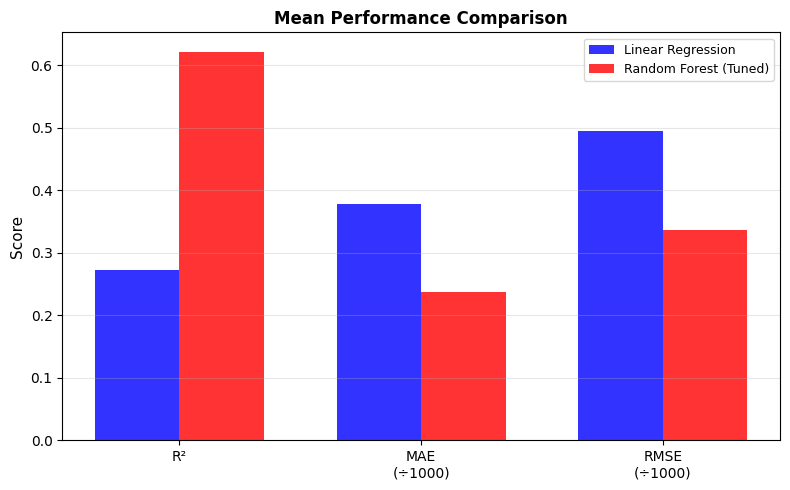

In [16]:
metrics_lr = [lr_mean_r2, lr_mean_mae/1000, lr_mean_rmse/1000]
metrics_rf = [rf_mean_r2, rf_mean_mae/1000, rf_mean_rmse/1000]

# Single plot: Mean Performance Comparison (R², MAE(÷1000), RMSE(÷1000))
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(3)
width = 0.35

ax.bar(x - width/2, metrics_lr, width, label='Linear Regression', color='blue', alpha=0.8)
ax.bar(x + width/2, metrics_rf, width, label='Random Forest (Tuned)', color='red', alpha=0.8)

ax.set_ylabel('Score', fontsize=11)
ax.set_title('Mean Performance Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['R²', 'MAE\n(÷1000)', 'RMSE\n(÷1000)'])
ax.legend(fontsize=9)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Results Summary

Loaded and preprocessed the Seoul bike dataset (parsed dates, created calendar features, encoded categoricals, and dropped a highly correlated feature).  
Used time-series cross-validation to train and evaluate a Linear Regression and a grid-searched Random Forest; the tuned Random Forest performed best (R² ≈ 0.60, MAE ≈ 243).

**Best Model:** Random Forest (Tuned)

**Performance:**
- R² = 0.60 (explains 60% of variance)
- MAE ≈ 243 bikes average error
- Better then simple Linear Regressor


# Model Interpretation

**Aim:** Understand what drives predictions and extract actionable insights

**Methods:**
- Feature Importance Rankings (Random Forest & Linear Regression)
- SHAP Values (SHapley Additive exPlanations)
- Partial Dependence Plots

---

## Setup and Libraries

In [17]:
from sklearn.inspection import PartialDependenceDisplay
import seaborn as sns
import shap
import os

# Import the SHAP helper functions
from helper_functions_shap import (
    compute_and_save_shap_full_dataset,
    load_shap_values,
    get_sample_for_plotting
)

# Create visualizations folder
visualizations = 'visualizations'
os.makedirs(visualizations, exist_ok=True)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Initialize SHAP
shap.initjs()

print(" All packages loaded successfully!")

 All packages loaded successfully!


## 3. Feature Importance Analysis

### 3.1 Random Forest Feature Importance


 Analyzing feature importance...

   Top 10 Most Important Features (Random Forest):
   ------------------------------------------------------------------
   Temperature(°C)                     : 0.3490
   Hour                                : 0.3100
   Solar Radiation (MJ/m2)             : 0.0971
   Humidity(%)                         : 0.0869
   DayOfWeek                           : 0.0413
   Rainfall(mm)                        : 0.0393
   Month                               : 0.0242
   Season_Winter                       : 0.0212
   Wind speed (m/s)                    : 0.0102
   Visibility (10m)                    : 0.0101
    Saved: feature_importance_rf.png


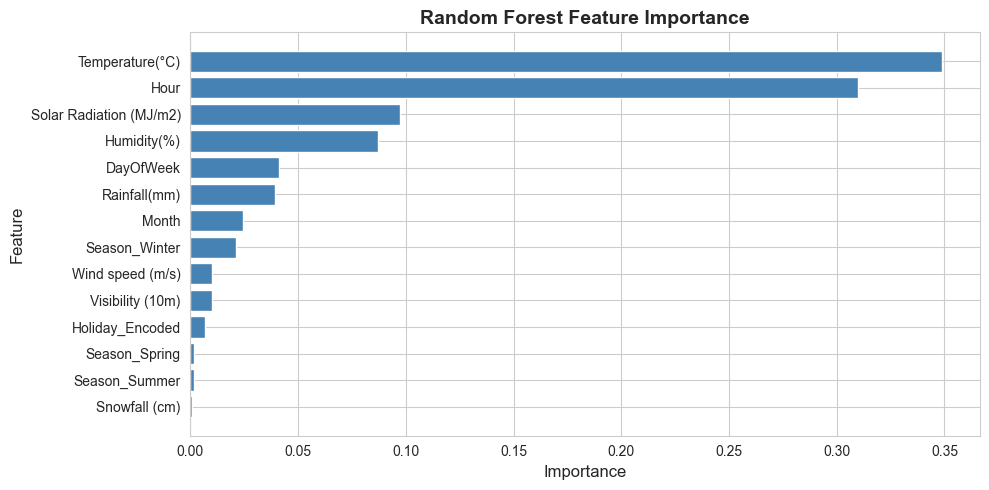

In [18]:
print("\n Analyzing feature importance...")

# Random Forest Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n   Top 10 Most Important Features (Random Forest):")
print("   " + "-"*66)
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['Feature']:35s} : {row['Importance']:.4f}")

# Visualize
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'{visualizations}/feature_importance_rf.png', dpi=300, bbox_inches='tight')
print("    Saved: feature_importance_rf.png")
plt.show()
plt.close()

### 3.2 Linear Regression Coefficients


   Top 5 Positive Contributors (Linear Regression):
   ------------------------------------------------------------------
   Snowfall (cm)                       : +30.20
   Hour                                : +28.69
   Temperature(°C)                     : +26.98
   Wind speed (m/s)                    : +16.76
   Month                               : +3.83

   Top 5 Negative Contributors (Linear Regression):
   ------------------------------------------------------------------
   Solar Radiation (MJ/m2)             : -83.73
   Season_Spring                       : -121.08
   Holiday_Encoded                     : -127.10
   Season_Summer                       : -146.63
   Season_Winter                       : -347.04
    Saved: coefficients_lr.png


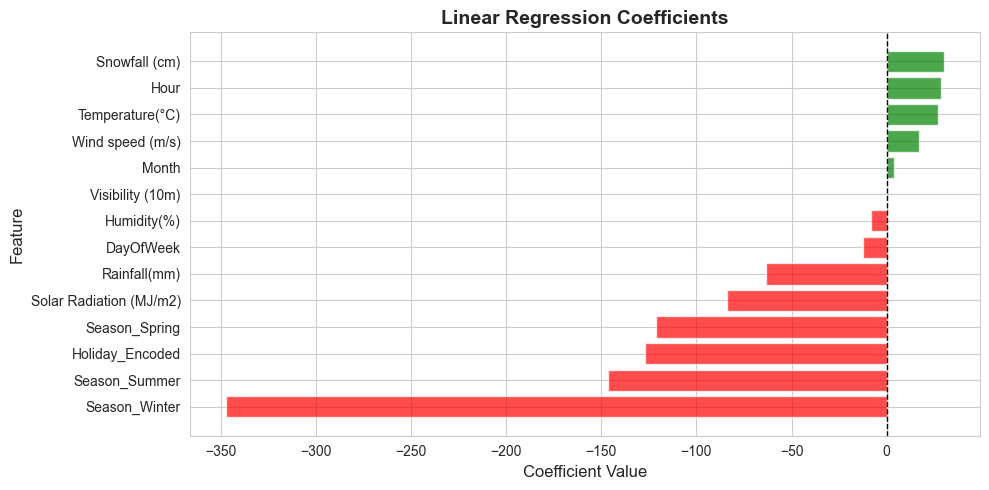

In [19]:
lr_model.fit(X, y)
# Linear Regression Coefficients
lr_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False)

print("\n   Top 5 Positive Contributors (Linear Regression):")
print("   " + "-"*66)
for idx, row in lr_coef.head(5).iterrows():
    print(f"   {row['Feature']:35s} : {row['Coefficient']:+.2f}")

print("\n   Top 5 Negative Contributors (Linear Regression):")
print("   " + "-"*66)
for idx, row in lr_coef.tail(5).iterrows():
    print(f"   {row['Feature']:35s} : {row['Coefficient']:+.2f}")

# Visualize
plt.figure(figsize=(10, 5))
colors = ['green' if c > 0 else 'red' for c in lr_coef['Coefficient']]
plt.barh(lr_coef['Feature'], lr_coef['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Linear Regression Coefficients', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'{visualizations}/coefficients_lr.png', dpi=300, bbox_inches='tight')
print("    Saved: coefficients_lr.png")
plt.show()
plt.close()

## 4. SHAP Analysis (Random Forest)

### 4.1 Compute SHAP Values

In [20]:
SHAP_SAVE_DIR = 'shap_values'
os.makedirs(SHAP_SAVE_DIR, exist_ok=True)

if os.path.exists('shap_values/shap_values_latest.pkl'):
    print("SHAP values already computed!")
    print("Loading existing SHAP values (instant)...")
    shap_data = load_shap_values(save_dir=SHAP_SAVE_DIR)
else:
    print("Computing SHAP values for FULL dataset...")
    print("This will take ~5-10 minutes but only needs to be done ONCE\n")
    
    # Compute and save SHAP for the FULL dataset
    shap_data = compute_and_save_shap_full_dataset(best_rf_model, X, save_dir=SHAP_SAVE_DIR)

print(f"\n SHAP values available for {shap_data['dataset_size']} samples")

Computing SHAP values for FULL dataset...
This will take ~5-10 minutes but only needs to be done ONCE

COMPUTING SHAP VALUES FOR FULL DATASET

Dataset size: 8465 samples
This may take several minutes for the full dataset...

[1/3] Creating SHAP explainer...
 Explainer created

[2/3] Computing SHAP values for 8465 samples...


SHAP Computation: 100%|██████████| 8465/8465 [53:26<00:00,  2.64samples/s]


[3/3] Saving SHAP values to disk...
 Saved to: shap_values\shap_values_full_dataset.pkl
 Also saved to: shap_values\shap_values_latest.pkl (for easy loading)
 File size: 1.83 MB

SHAP VALUES SAVED SUCCESSFULLY!

 SHAP values available for 8465 samples


### 4.2 SHAP Summary Plots

In [21]:
'''
Generate Visualization only for a sample or for the entire dataset 
'''

# shap_values_rf, X_sample = get_sample_for_plotting(
#     shap_data, 
#     sample_size=1000,
#     random_state=42
# )

shap_values_rf, X_sample = get_sample_for_plotting(shap_data)


   Generating SHAP visualizations...


C:\Users\Anton\AppData\Local\Temp\ipykernel_16280\910336128.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_sample, plot_type="dot", show=False)


    Saved: shap_summary_dot.png


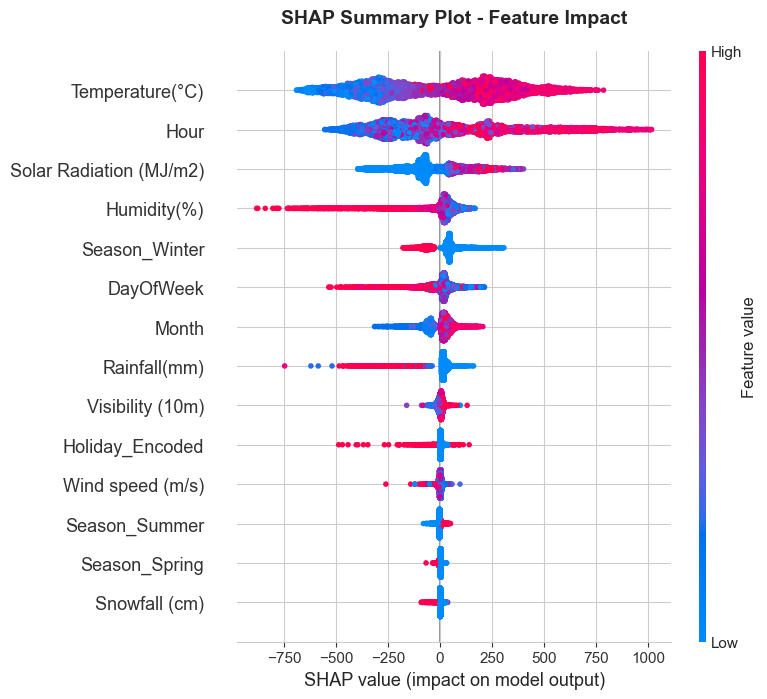

In [22]:
print("\n   Generating SHAP visualizations...")

# SHAP Summary Plot (dot)
plt.figure(figsize=(16, 4))
shap.summary_plot(shap_values_rf, X_sample, plot_type="dot", show=False)
plt.title('SHAP Summary Plot - Feature Impact', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{visualizations}/shap_summary_dot.png', dpi=300, bbox_inches='tight')
print("    Saved: shap_summary_dot.png")
plt.show()
plt.close()

C:\Users\Anton\AppData\Local\Temp\ipykernel_16280\214099949.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_sample, plot_type="bar", show=False)


 Saved: shap_summary_bar.png


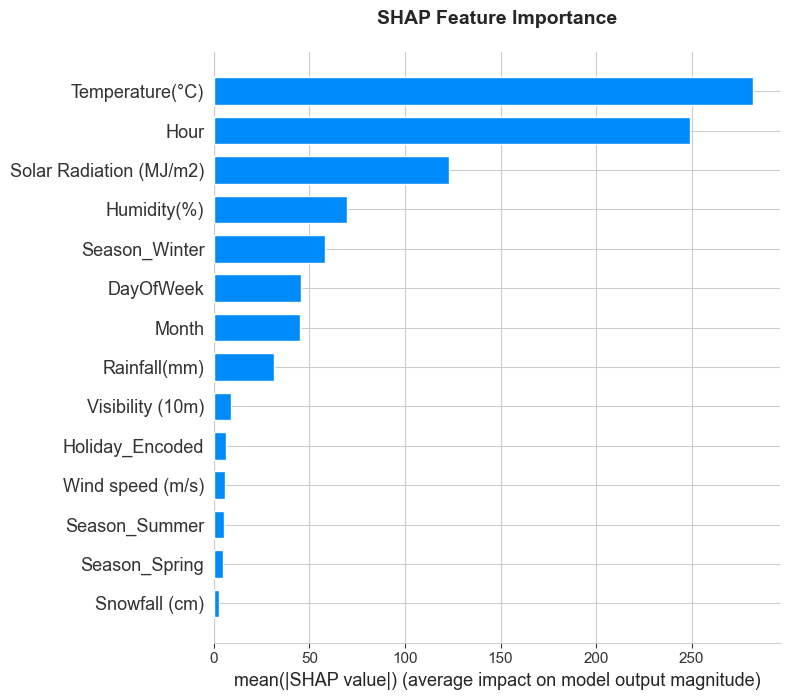

In [23]:
# SHAP Bar Plot
plt.figure(figsize=(10, 4))
shap.summary_plot(shap_values_rf, X_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{visualizations}/shap_summary_bar.png', dpi=300, bbox_inches='tight')
print(" Saved: shap_summary_bar.png")
plt.show()
plt.close()

### 4.3 SHAP Dependence Plots

 Saved: shap_dependence_plots.png


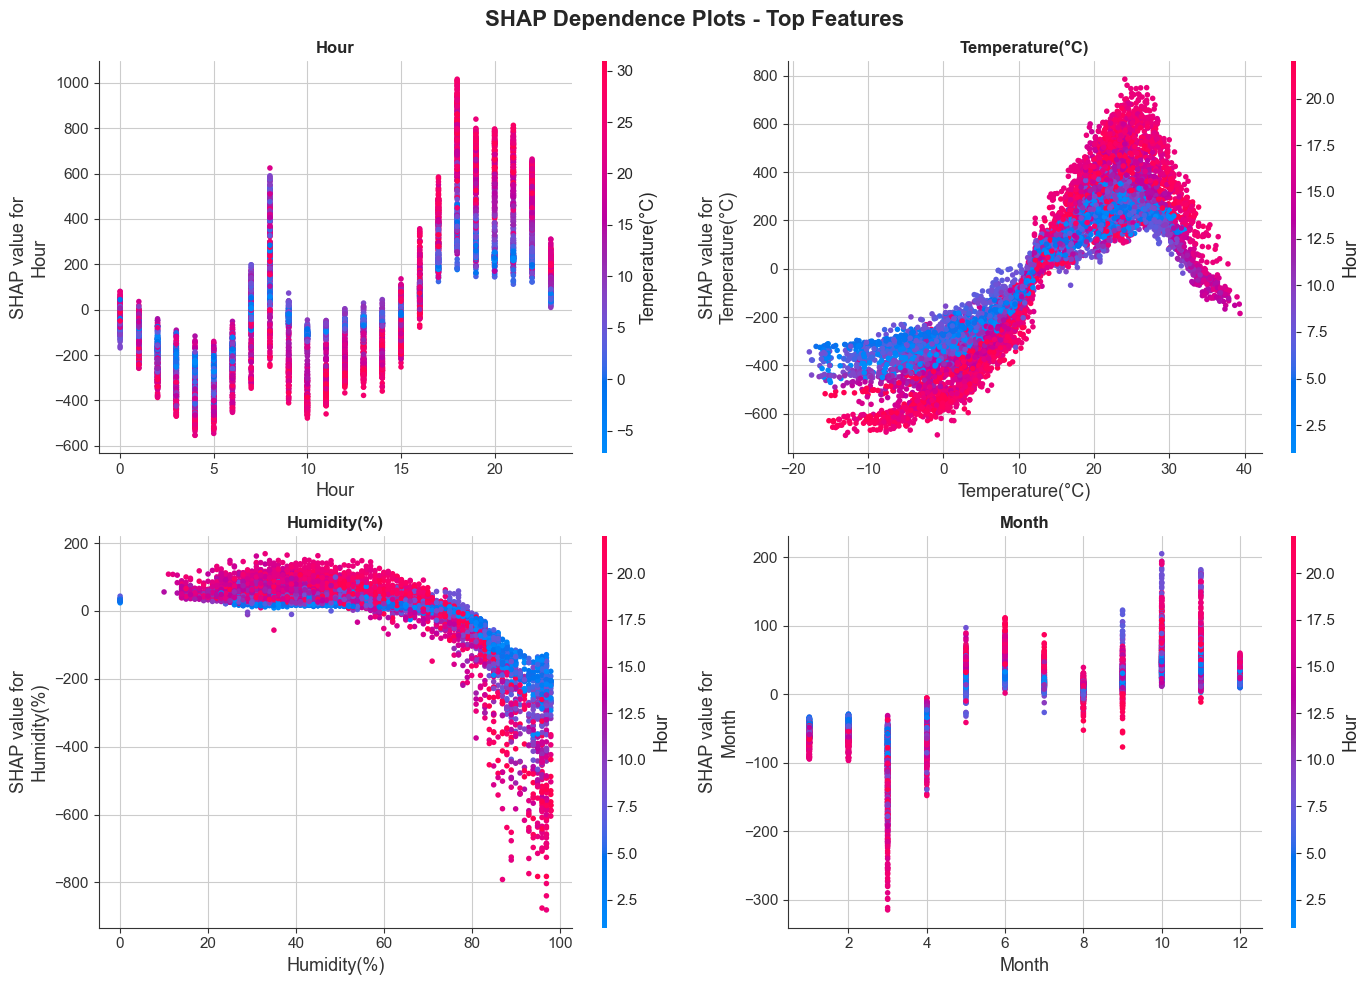

In [24]:
# SHAP Dependence Plots
top_features = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Month']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('SHAP Dependence Plots - Top Features', fontsize=16, fontweight='bold')

for idx, feature in enumerate(top_features):
    row = idx // 2
    col = idx % 2
    shap.dependence_plot(feature, shap_values_rf, X_sample, ax=axes[row, col], show=False)
    axes[row, col].set_title(f'{feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{visualizations}/shap_dependence_plots.png', dpi=300, bbox_inches='tight')
print(" Saved: shap_dependence_plots.png")
plt.show()
plt.close()

## 5. Partial Dependence Plots

### 5.1 1D Partial Dependence Plots


 Creating Partial Dependence Plots...


c:\Users\Anton\OneDrive\Desktop\WS25\DDS\dds_group_16\dds_venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\Anton\OneDrive\Desktop\WS25\DDS\dds_group_16\dds_venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


 Saved: partial_dependence_1d.png


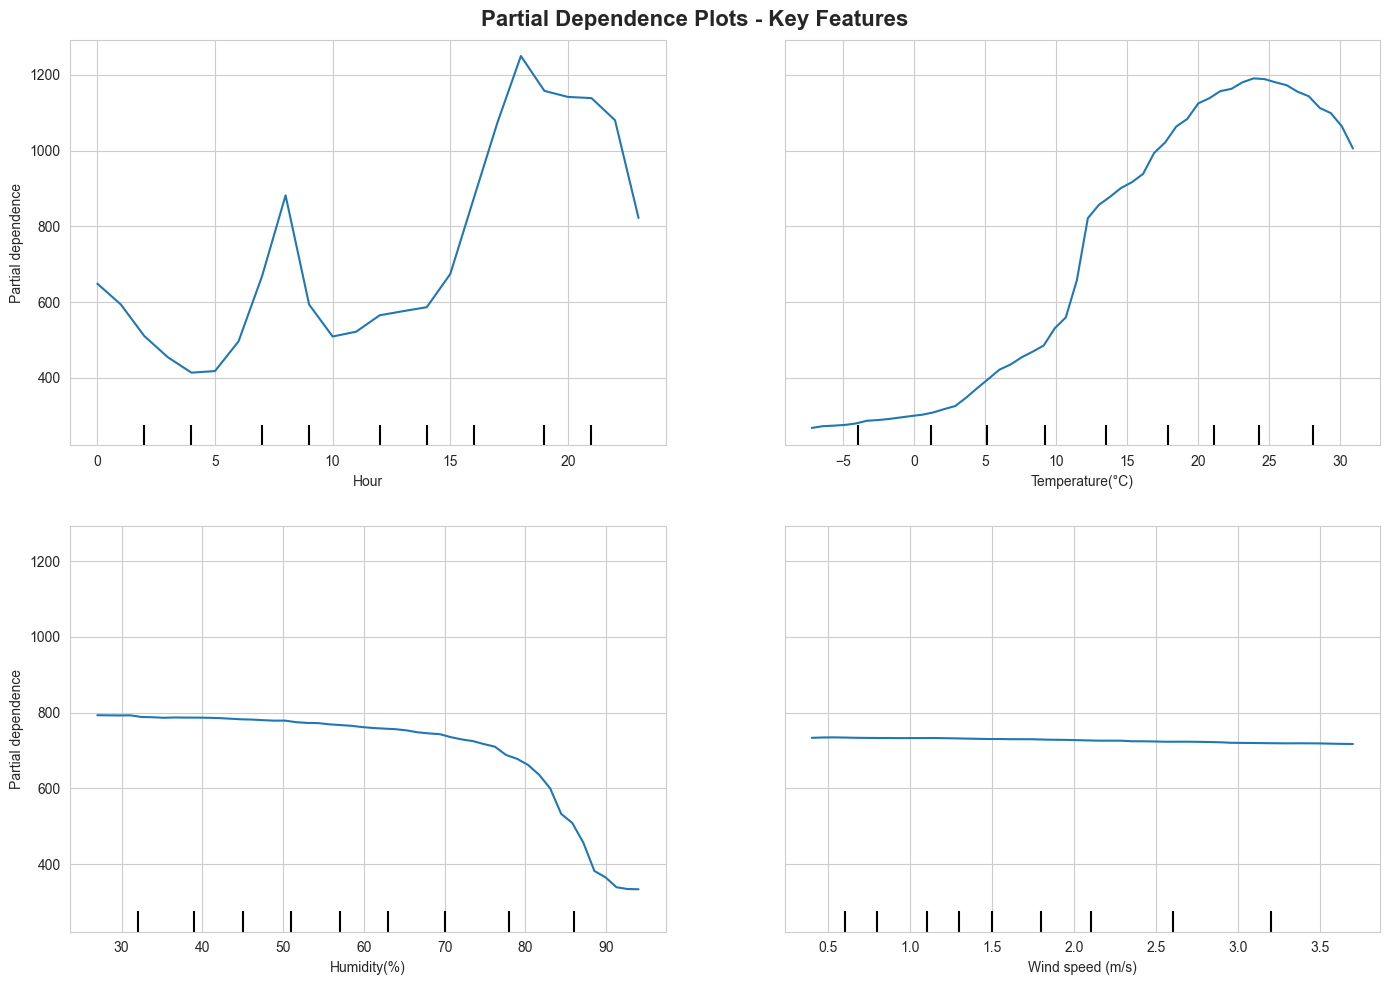

In [26]:
print("\n Creating Partial Dependence Plots...")

# 1D PDPs
key_features = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']
feature_indices = [X.columns.get_loc(f) for f in key_features]

fig, ax = plt.subplots(figsize=(14, 10))
display = PartialDependenceDisplay.from_estimator(
    best_rf_model, X, features=feature_indices,
    feature_names=X.columns, n_cols=2, grid_resolution=50, ax=ax
)
fig.suptitle('Partial Dependence Plots - Key Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{visualizations}/partial_dependence_1d.png', dpi=300, bbox_inches='tight')
print(" Saved: partial_dependence_1d.png")
plt.show()
plt.close()

### 5.2 2D Partial Dependence Plot (Hour × Temperature)

c:\Users\Anton\OneDrive\Desktop\WS25\DDS\dds_group_16\dds_venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


 Saved: partial_dependence_2d.png


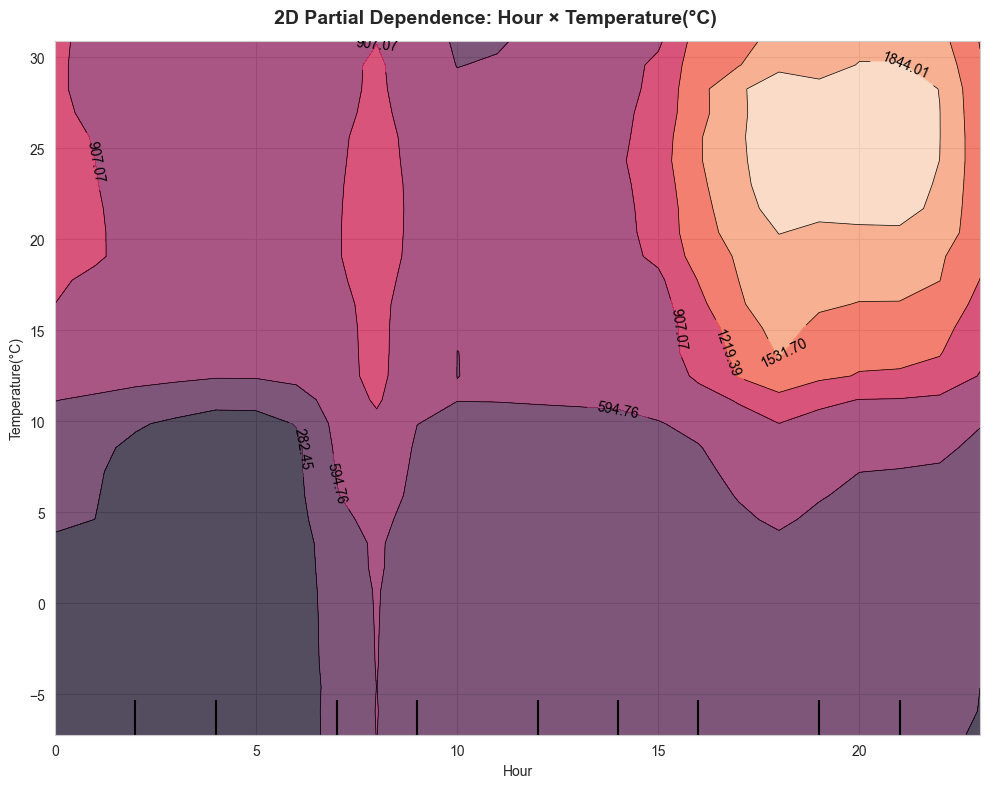

In [27]:
# 2D PDP: Hour × Temperature
fig, ax = plt.subplots(figsize=(10, 8))
display = PartialDependenceDisplay.from_estimator(
    best_rf_model, X, features=[(0, 1)],
    feature_names=X.columns, grid_resolution=30, ax=ax
)
plt.suptitle('2D Partial Dependence: Hour × Temperature(°C)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{visualizations}/partial_dependence_2d.png', dpi=300, bbox_inches='tight')
print(" Saved: partial_dependence_2d.png")
plt.show()
plt.close()